In [1]:
pip install simpy networkx qutip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 19.5 MB/s eta 0:00:00


In [2]:
import simpy
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from qutip import sigmaz, Qobj, basis, tensor, qeye
import seaborn as sns

# Network Simulation

In [4]:
# Define a frame class to represent the frames being transferred in the network
class Frame:
    def __init__(self, env, source, destination, frame_id, guard_time, storage_time_limit):
        self.env = env  # Simulation environment
        self.source = source  # Source node of the frame
        self.destination = destination  # Destination node of the frame
        self.creation_time = env.now  # Timestamp of frame creation
        self.status = 'in transit' # Status of the frame: 'in transit', 'discarded' or 'arrived'
        self.path_traveled = [source]  # Path the frame has traveled
        self.frame_id = frame_id  # Unique identifier for the frame
        self.time_in_memory = 0  # Time spent in storage
        self.queue_entry_time = None  # Time when the frame is added to the queue
        self.guard_time = guard_time  # Guard time for frame integrity
        self.payload_time = 1
        self.temporal_frame_length = self.guard_time + self.payload_time  # Length of the frame in time units
        self.num_times_entered_storage = 0 # number of times a frame has entered storage
        self.time_in_queue = 0
        self.time_in_existence = None
        self.storage_time_limit = storage_time_limit # Maximum allowed storage time

    def update_time_in_queue(self, time_in_queue):
        self.time_in_queue += time_in_queue

    def update_frame_from_processing(self, pretransmission_delay, frame_length_before_processing):
        '''
        pretransmission delay: queuing and header processing delay
        transmission delay: temporal frame length
        '''
        # checking for invalid times
        if pretransmission_delay < 0 or self.guard_time < 0:
            raise ValueError("Invalid time value")

        # if the guard time is larger then it is reduced, no time in storage
        elif self.guard_time >= pretransmission_delay:
            self.guard_time -= pretransmission_delay
            self.temporal_frame_length -= pretransmission_delay

        # if the time delay is less then the guard time then the guard time
        # becomes zero and the packet is in storage after the guard time is used up
        elif self.guard_time < pretransmission_delay:
            self.temporal_frame_length -= self.guard_time
            self.time_in_memory += (pretransmission_delay - self.guard_time + frame_length_before_processing / 2)
            self.num_times_entered_storage += 1
            self.guard_time = 0


        # checking if storage time limit has been reached
        if self.time_in_memory > self.storage_time_limit:
            self.status = 'discarded'

class NetworkNode:
    def __init__(self, env, name, node_type, header_processing, k=1):
        self.env = env  # Simulation environment
        self.name = name  # Name of the node
        self.node_type = node_type  # Type of node: 'sender', 'router', or 'receiver'
        self.queue = simpy.Store(env)  # Queue to store frames
        self.resource = simpy.Resource(env, capacity=k)  # Resource to handle k simultaneous processes
        self.header_processing = header_processing

    def process_frames(self, print_status):
        while True:
            frame = yield self.queue.get()  # Get the next frame from the queue
            with self.resource.request() as request:
                yield request  # Wait until the resource is available

                queue_exit_time = self.env.now  # Record the time when the frame is retrieved from the queue
                time_in_queue = queue_exit_time - frame.queue_entry_time  # Calculate time spent in the queue
                frame.update_time_in_queue(time_in_queue)
                if print_status:
                    print(f"Time {self.env.now}: Frame {frame.frame_id} spent {time_in_queue} time units in queue at {self.name}")

                if frame.status == 'discarded':
                    if print_status:
                        print(f"Time {self.env.now}: Frame {frame.frame_id} discarded at {self.name}")
                    continue  # Skip further processing if frame is discarded

                if self.node_type in ['router', 'receiver']:
                    # Simulate header processing delay for routers and receivers
                    yield self.env.timeout(self.header_processing)

                    # update the frame with the total delay time at this node
                    total_preprocessing_delay = self.header_processing + time_in_queue

                    frame_length_before_processing = frame.temporal_frame_length
                    frame.update_frame_from_processing(total_preprocessing_delay, frame_length_before_processing)

                    frame_length_after_processing = frame.temporal_frame_length
                    yield self.env.timeout(frame_length_after_processing)

                    if frame.status == 'discarded':
                        if print_status:
                            print(f"Time {self.env.now}: Frame {frame.frame_id} discarded at {self.name}")
                        continue  # Skip further processing if frame is discarded

                if self.name != frame.destination:
                    # If the current node is not the destination, forward the frame
                    self.env.process(route_frame(self.env, frame, network, self, print_status))
                else:
                    # If the current node is the destination, deliver the frame
                    frame.status = 'arrived'
                    frame.time_in_existence = self.env.now - frame.creation_time
                    if print_status:
                        print(f"Time {self.env.now}: Frame {frame.frame_id} delivered at {self.name}, from {frame.source} to {frame.destination}")

    def put_frame_in_queue(self, frame):
        frame.queue_entry_time = self.env.now  # Record the time when the frame is added to the queue
        self.queue.put(frame)

# Define a function to generate frames at a given source node
def generate_frames(env, source_node, destination, interval, max_packets, guard_time, storage_time_limit, print_status):
    packet_count = 0  # Counter for the number of packets generated
    while packet_count < max_packets:
        yield env.timeout(interval)  # Wait for the next frame generation interval
        # Create a new frame with example attributes
        frame = Frame(env, source_node.name, destination, packet_count + 1, guard_time, storage_time_limit)
        source_node.put_frame_in_queue(frame)  # Put the frame in the source node's queue using the correct method
        if print_status:
            print(f"\nTime {env.now}: Frame {frame.frame_id} created at {source_node.name}, destined for {destination}")
        frames.append(frame)  # Collect the frame for visualization
        packet_count += 1  # Increment the packet counter

def route_frame(env, frame, network, current_node, print_status):
    # Calculate the shortest path from the current node to the destination
    all_paths = list(nx.all_shortest_paths(network, source=current_node.name, target=frame.destination, weight='weight'))
    path = random.choice(all_paths)

    # Determine the next hop in the path
    next_hop = path[1]
    # Get the next node object from the dictionary
    next_node = node_dict[next_hop]

    yield env.timeout(0)

    frame.path_traveled.append(next_hop)  # Record the path traveled
    if print_status:
        print(f"\nTime {env.now}: Frame {frame.frame_id} forwarded from {current_node.name} to {next_hop}")
    # Put the frame in the next node's queue
    next_node.put_frame_in_queue(frame)

def create_linear_graph(network, num_nodes):
    nodes = []
    for i in range(num_nodes):
        node = f'Node_{i}'
        nodes.append(node)
        network.add_node(node)
        # Connect each node to the next one
        if i > 0:
            network.add_edge(nodes[i - 1], node, weight=1)
            network.add_edge(node, nodes[i - 1], weight=1)
    return nodes

def initialize_simulation(num_nodes, sender, receiver, header_processing):
    """
    num_nodes=int
    sender = int, index of sender node
    receiver = int, index of receiver node
    """
    global env, network, node_dict, frames
    env = simpy.Environment()
    network = nx.Graph()
    frames = []

    # Create a linear graph of nodes
    nodes = create_linear_graph(network, num_nodes)

    # Define node types (for simplicity, all nodes are routers except the sender and receiver)
    node_types = {}
    for i in range(num_nodes):
        if i == sender:
            node_types[f'Node_{i}'] = 'sender'
        elif i == receiver:
            node_types[f'Node_{i}'] = 'receiver'
        else:
            node_types[f'Node_{i}'] = 'router'

    # Create network node objects and store them in a dictionary
    node_dict = {name: NetworkNode(env, name, node_types[name], header_processing, k=1) for name in nodes}


def retry_discarded_frames(sender, receiver, max_retries, print_status):
    retries = 0
    while retries < max_retries:
        discarded_frames = [frame for frame in frames if frame.status == 'discarded' or frame.path_traveled[-1] != f'Node_{receiver}']

        if not discarded_frames:
            break  # Exit the loop if no frames need to be resent
        if print_status:
            print('\n')
        for frame in discarded_frames:
            # Reset parameters
            frame.creation_time = frame.env.now
            frame.status = 'in transit'
            frame.path_traveled = [frame.source]  # Reset path traveled
            frame.time_in_memory = 0
            frame.guard_time = 3
            frame.temporal_frame_length = frame.guard_time + frame.payload_time
            frame.num_times_entered_storage = 0
            frame.time_in_queue = 0

            if print_status:
                print(f"Retrying frame {frame.frame_id}, new status: {frame.status}")
            node_dict[f'Node_{sender}'].put_frame_in_queue(frame)  # Resend frame from the sender node
        if print_status:
            print('\n')
        # Run the simulation again for the resent frames
        while any(frame.status == 'in transit' for frame in frames):
            env.step()

        retries += 1

    return retries


def run_simulation(max_packets, interval, num_nodes, sender, receiver, guard_time, header_processing, storage_time_limit, max_retries=10, print_status=False):
    initialize_simulation(num_nodes, sender, receiver, header_processing)

    # Start the frame generation process at the sender node, creating frames destined for the receiver node
    env.process(generate_frames(env, node_dict[f'Node_{sender}'], f'Node_{receiver}', interval, max_packets, guard_time, storage_time_limit, print_status))

    # Start the frame processing process for each node in the network
    for node in node_dict.values():
        env.process(node.process_frames(print_status))

    # Run the simulation until all packets are generated and processed
    while len(frames) < max_packets or any(frame.status == 'in transit' for frame in frames):
        env.step()

    # Retry sending any discarded packets max_retries times
    retries = retry_discarded_frames(sender, receiver, max_retries, print_status)

    # Count packets received and not received
    received_count = sum(1 for frame in frames if frame.status == 'arrived')
    not_received_count = len(frames) - received_count
    discarded_frame_ids = [frame.frame_id for frame in frames if frame.status == 'discarded']
    simulation_time = env.now - interval

    if not_received_count != 0:
        raise UserWarning(f"All packets not sent after {max_retries} retries")

    # Create a dictionary to store paths traveled and time in memory for each frame
    frame_stats = {frame.frame_id: {'num_nodes_travelled': len(frame.path_traveled),
                                    'time_in_memory': frame.time_in_memory,
                                    'times_entered_memory': frame.num_times_entered_storage,
                                    'time_in_queue': frame.time_in_queue,
                                    'time_in_existence':frame.time_in_existence} for frame in frames}

    return frame_stats, simulation_time, retries


def print_frame_stats(frame_stats):
    print('')
    for frame_id, stats in frame_stats.items():
        print(f"Frame {frame_id}:")
        print(f"  Time in memory: {stats['time_in_memory']}")
        print(f"  Time in queue: {stats['time_in_queue']}")
        print(f"  Times entered memory:' {stats['times_entered_memory']}")
        print(f"  Time in existence:' {stats['time_in_existence']}")


# Loss and Dephasing Model

In [8]:
zero = basis(2,0)
one = basis(2,1)

# Define the fidelity calculation function
def fidelity_after_memory(frame_stats, T_dp=1):
    """
    Applies the dephasing channel to a given density matrix `rho` and calculates fidelity.

    Parameters:
    t (float): The time over which the dephasing occurs.
    T_dp (float): The dephasing time constant.

    Returns:
    float: The fidelity of the quantum state after dephasing.
    """
    I = qeye(2)
    Z = sigmaz()
    num_frames = len(frame_stats)
    ket0 = (tensor(one, one) + tensor(zero, zero)).unit()
    rho0 = ket0 * ket0.dag()
    dp_prob = lambda t: (1 - np.exp(-t / T_dp)) / 2
    rho_t = Qobj(np.zeros((4, 4)), dims=[[2, 2], [2, 2]]) # empty Qobj
    time_in_memory_list = []
    time_in_existence_list = []


    for frame_id, stats in frame_stats.items():
        time_in_existence_list.append(stats['time_in_existence'])
        time_in_memory_list.append(stats['time_in_memory'])

    avg_mem_t = np.mean(time_in_memory_list)
    avg_existence_t = np.mean(time_in_existence_list)

    #print('                           Average memory time:', avg_mem_t)
    #print('   Average existence time', avg_existence_t)
    p1 = dp_prob(avg_existence_t)
    p2 = dp_prob(avg_mem_t)

    op1 = (1 - p1) * (1 - p2) * tensor(I, I)
    op2 = (1 - p1) * p2 * tensor(I, Z)
    op3 = p1 * (1 - p2) * tensor(Z, I)
    op4 = p1 * p2 * tensor(Z, Z)

    ops = [op1, op2, op3, op4]

    for op in ops:
      rho_t += op * rho0 * op.dag()

    fidelity = np.real(ket0.dag() * rho_t * ket0)
    return fidelity


# Fiber and memory loss functions
def fiber_loss(a, d):
    return d * a

def memory_loss(a, t, avg_times_frame_enters_storage):
    minimum_insertion_loss = 4
    avg_insertion_loss = minimum_insertion_loss * avg_times_frame_enters_storage
    return t * c * a + avg_insertion_loss

# Rate of BP received function
def rate_bp_received(frame_stats, simulation_time, bp_per_frame_initial=1e7, a_fiber=1e-7, a_memory=0.01):
    num_frames = len(frame_stats)

    # average number of times a packet enters storage
    total_times_packets_enters_storage = sum(stats['times_entered_memory'] for stats in frame_stats.values())
    avg_times_frame_enters_storage = total_times_packets_enters_storage / num_frames if frame_stats else 0

    # calculating average distance travelled by the frames
    total_nodes = sum(stats['num_nodes_travelled'] for stats in frame_stats.values())
    avg_nodes = total_nodes / num_frames if frame_stats else 0
    avg_d = d_between_nodes * (avg_nodes - 1)

    # calculating average time spent in storage
    total_time_in_memory = sum(stats['time_in_memory'] for stats in frame_stats.values())
    avg_mem_t = total_time_in_memory / num_frames

    loss = fiber_loss(a_fiber, avg_d) #+ memory_loss(a_memory, avg_mem_t, avg_times_frame_enters_storage)
    avg_bp_per_frame = bp_per_frame_initial * 10 ** (-loss / 10)

    rate_bp_received = num_frames * avg_bp_per_frame / simulation_time
    return rate_bp_received

# Parameters

In [17]:
c = 2e8 # speed of light in fiber
d_between_nodes = 100e3

max_packets = 10  # Number of packets to generate and process
num_nodes = 6  # Number of nodes in the linear graph
sender = 0  # Index of the sender node
receiver = 5  # Index of the receiver node
header_processing = 1
storage_time_limit = 10

# Running Network Simulation For Varying Guard Time and Interval

In [18]:
# Define ranges for guard_time and interval
guard_time_range = np.linspace(0, 30, 41)
interval_range = np.linspace(0, 30, 41)

# Initialize list to store results
results = []

# Run simulations for each combination of guard_time and interval
for interval in interval_range:
    for guard_time in guard_time_range:
        #print(f"\nInterval: {interval}, Guard Time: {guard_time}")
        frame_stats, simulation_time, retries = run_simulation(max_packets, interval, num_nodes, sender, receiver, guard_time, header_processing, storage_time_limit, max_retries=11)
        rate = rate_bp_received(frame_stats, simulation_time, a_memory=0.001)
        fidelity = fidelity_after_memory(frame_stats, T_dp=50)
        results.append({'interval': interval, 'guard_time': guard_time, 'rate_bp_received': rate, 'fidelity': fidelity})

# Convert results to a pandas DataFrame
df = pd.DataFrame(results)

## Heat Map For Results

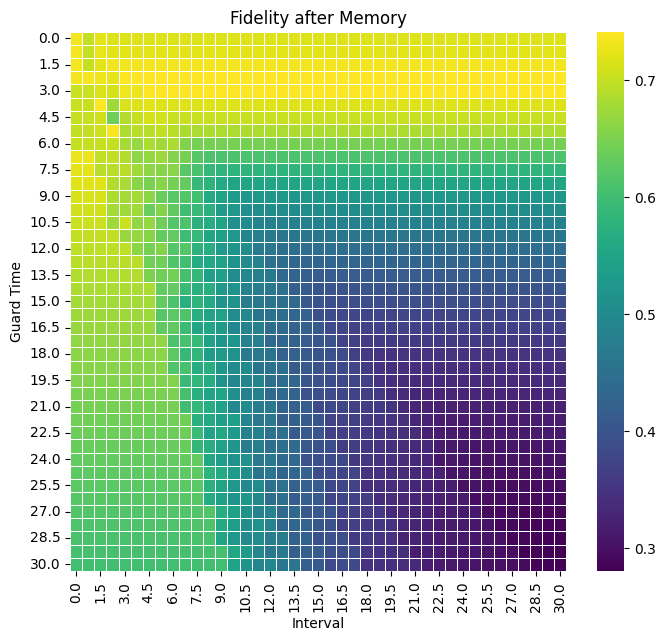

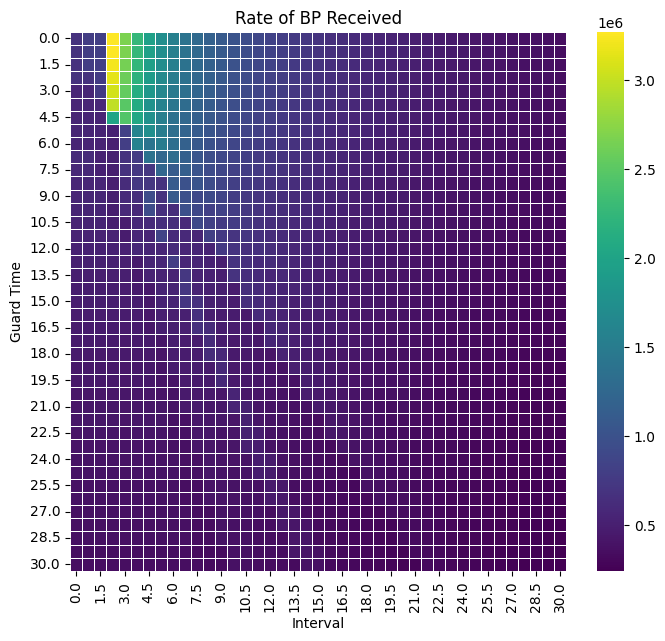

In [19]:
# Heatmap for fidelity
plt.figure(figsize=(8, 7))
fidelity_pivot = df.pivot(index='guard_time', columns='interval', values='fidelity')
sns.heatmap(fidelity_pivot, cmap='viridis', fmt=".2f", linewidths=0.4, linecolor='white')
plt.title('Fidelity after Memory')
plt.xlabel('Interval')
plt.ylabel('Guard Time')
plt.show()

# Heatmap for rate_bp_received
plt.figure(figsize=(8, 7))
rate_pivot = df.pivot(index='guard_time', columns='interval', values='rate_bp_received')
sns.heatmap(rate_pivot, cmap='viridis', fmt=".2f", linewidths=0.4, linecolor='white')
plt.title('Rate of BP Received')
plt.xlabel('Interval')
plt.ylabel('Guard Time')
plt.show()

## 3D Plots For Results

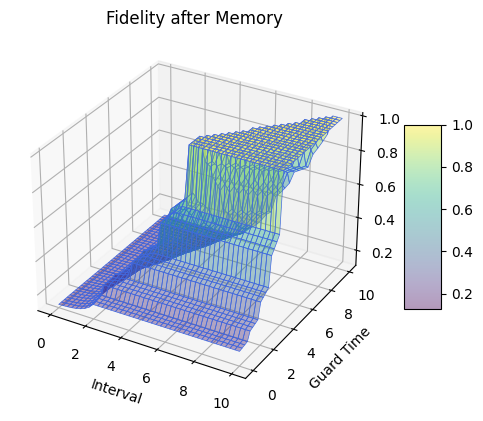

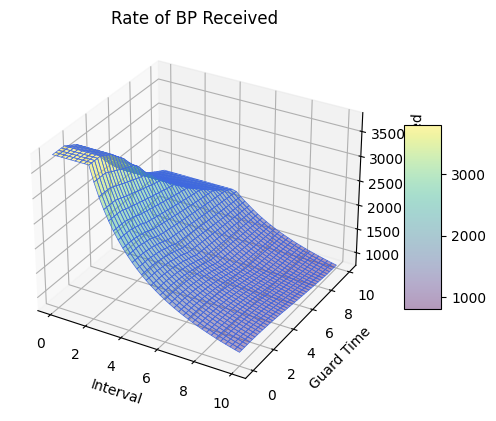

In [58]:
# Create 3D plot for fidelity
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(interval_range, guard_time_range)
Z = df.pivot(index='guard_time', columns='interval', values='fidelity').values

surface = ax.plot_surface(X, Y, Z, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.4, cmap='viridis')
#contour = ax.contour(X, Y, Z, zdir='z', offset=np.min(Z), cmap='viridis')
ax.set_xlabel('Interval')
ax.set_ylabel('Guard Time')
ax.set_zlabel('Fidelity')
ax.set_title('Fidelity after Memory')
fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)

plt.show()

# Create 3D plot for rate_bp_received
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

Z_rate = df.pivot(index='guard_time', columns='interval', values='rate_bp_received').values

surface_rate = ax.plot_surface(X, Y, Z_rate, edgecolor='royalblue', lw=0.5, rstride=1, cstride=1, alpha=0.4, cmap='viridis')
#contour_rate = ax.contour(X, Y, Z_rate, zdir='z', offset=np.min(Z_rate), cmap='viridis', alpha = 0.3)
ax.set_xlabel('Interval')
ax.set_ylabel('Guard Time')
ax.set_zlabel('Rate of BP Received')
ax.set_title('Rate of BP Received')
fig.colorbar(surface_rate, ax=ax, shrink=0.5, aspect=5)

plt.show()

# Testing Specific Cases
With variables the same as above

In [144]:
initial_guard_time = 30
interval = 30
frame_stats, simulation_time, retries = run_simulation(max_packets, interval, num_nodes, sender, receiver, initial_guard_time, header_processing, storage_time_limit, print_status=False)

print_frame_stats(frame_stats)
print('\n')
fidelity_after_memory(frame_stats, T_dp=5)


Frame 1:
  Time in memory: 0
  Time in queue: 0
  Times entered memory:' 0
  Time in existence:' 145
Frame 2:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 3:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 4:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 5:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 6:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 7:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 8:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 9:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in existence:' 141
Frame 10:
  Time in memory: 0
  Time in queue: 1
  Times entered memory:' 0
  Time in exis

0.25000000000026124

# Testing fidelity function

In [105]:
I = qeye(2)
Z = sigmaz()
T_dp = 5

ket0 = (tensor(one, one) + tensor(zero, zero)).unit()
rho0 = ket0 * ket0.dag()
dp_prob = lambda t: (1 - np.exp(-t / T_dp)) / 2
rho_t = Qobj(np.zeros((4, 4)), dims=[[2, 2], [2, 2]]) # empty Qobj

# calculating average time spent in memory
avg_mem_t = 0

# calculating average time in existence
avg_existence_t = 81


p1 = dp_prob(avg_existence_t)
p2 = dp_prob(avg_mem_t)

op1 = (1 - p1) * (1 - p2) * tensor(I, I)
op2 = (1 - p1) * p2 * tensor(I, Z)
op3 = p1 * (1 - p2) * tensor(Z, I)
op4 = p1 * p2 * tensor(Z, Z)

ops = [op1, op2, op3, op4]

for op in ops:
  rho_t += op * rho0 * op.dag()

fidelity = np.real(ket0.dag() * rho_t * ket0)
fidelity

0.2500000460680062

In [ ]:
fidelity_after_memory(frame_stats)